In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
import joblib
warnings.filterwarnings('ignore')

In [393]:
data = pd.read_csv("Medicalpremium.csv")

In [394]:
df = data.copy()

In [395]:
subset_selection_features = ["Age", "AnyTransplants", "AnyChronicDiseases", "HistoryOfCancerInFamily",
                             "NumberOfMajorSurgeries", "BMI"]

In [396]:
def mape(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"MAPE for data: {mape:.2f}%")

# Custom transformers

In [397]:
class upsample(BaseEstimator, TransformerMixin):
    def __init__(self, category="NumberOfMajorSurgeries", cls=3, nSamples=100):
        self.category = category
        self.nSamples = nSamples
        self.cls = cls

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sample = resample(X[X[self.category] == self.cls], n_samples=self.nSamples, replace=True)
        X = pd.concat([X[X[self.category] != self.cls], sample])
        X.reset_index(drop=True, inplace=True)
        return X

In [398]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            X = X.drop(["Weight", "Height"], axis=1)
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    #X = X.drop(["Weight", "Height"], axis=1)
                    return X
            else:
                #X = X.drop(["Weight", "Height"], axis=1)
                return X
        else:
            return X

In [399]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [400]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [401]:
class featureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if (self.columns is None):
            self.columns = X.columns
        return X[self.columns]

# preprocessing

In [402]:
#dt = upsample(category= "NumberOfMajorSurgeries", cls=3, nSamples=100).transform(df.copy())
dt = df.copy()

In [403]:
X = dt.drop("PremiumPrice", axis=1)
y = dt.PremiumPrice.copy()

In [404]:
X.shape

(986, 10)

In [405]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [406]:
pipe1 = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler()),
    ('feature_selction', featureSelection())
])

In [407]:
pipe2 = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler()),
    ('feature_selction', featureSelection(subset_selection_features))
])

# Random Forest

In [408]:
from sklearn.ensemble import RandomForestRegressor

In [409]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [410]:
forest_reg = RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=3)

In [411]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [412]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=3, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [413]:
pred = forest_reg.predict(X_test)

In [414]:
np.sqrt(mean_squared_error(y_test, pred))

2782.5272655703493

In [415]:
#train rmse
np.sqrt(mean_squared_error(y_train, forest_reg.predict(X_train)))

2565.8035965899453

In [416]:
mape(y_test, pred)

MAPE for data: 6.49%


[0.00446158 0.00645602 0.09366808 0.04782364 0.00222033 0.02038219
 0.02277271 0.72566486 0.07655059]


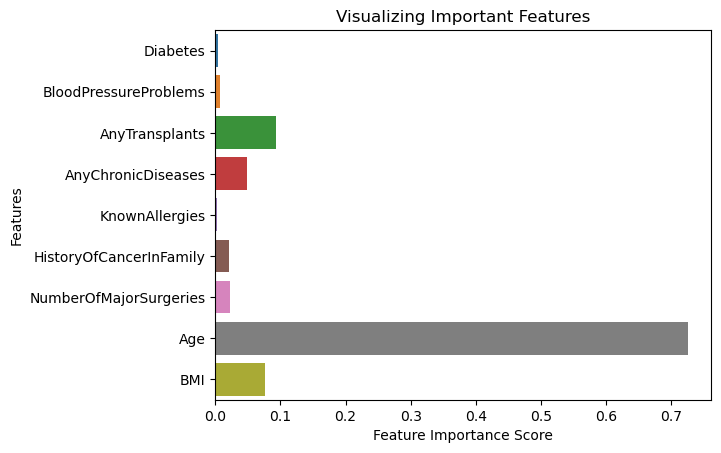

In [417]:
feature_imp1 = forest_reg.feature_importances_
print(feature_imp1)

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

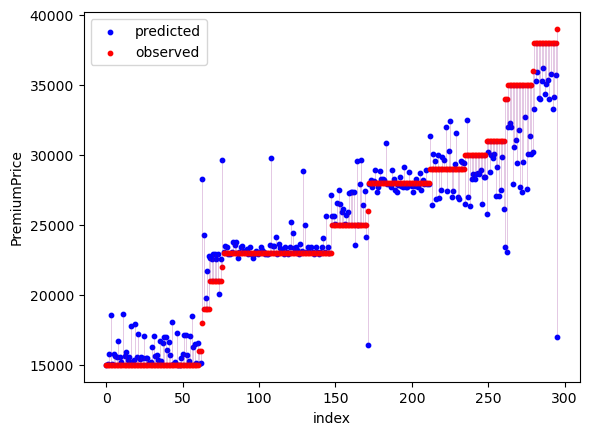

In [418]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## cross validation forest

In [419]:
scores = cross_val_score(forest_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

In [420]:
forest_rmse_scores = np.sqrt(-scores)

In [421]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [422]:
display_scores(forest_rmse_scores)

Scores: [3523.75871078 3563.16056724 3357.62895868 3548.90072976 4131.29903188
 3796.37916517 1844.63989033 2228.76928494 2242.11307413 3618.80575494]
Mean: 3185.545516784857
Standard deviation: 740.09569210266


## learning curve

In [423]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = forest_reg,
X = X_train,
y = y_train,
    cv = 5,
scoring = 'neg_mean_squared_error')

In [424]:
train_scores = np.sqrt(-train_scores)
validation_scores = np.sqrt(-validation_scores)

In [425]:
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

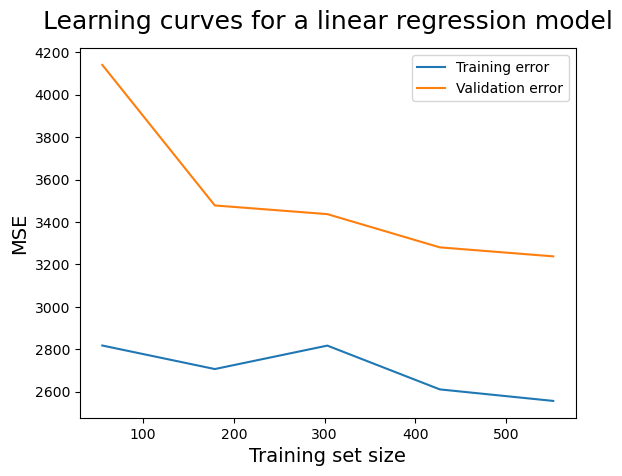

In [426]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

## feature selected

In [427]:
X_train = pipe2.fit_transform(x_train.copy())
X_test = pipe2.fit_transform(x_test.copy())

In [428]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=3, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [429]:
pred = forest_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

2804.8596103226687

In [430]:
#train rmse
np.sqrt(mean_squared_error(y_train, forest_reg.predict(X_train)))

2622.973584513472

In [431]:
#cross validation
scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

display_scores(np.sqrt(-scores))

Scores: [3521.8124575  3590.16310018 3335.90002062 3694.21323543 4097.15155343
 3707.26545974 1887.61385485 2341.88335886 2155.73836844 3665.29014369]
Mean: 3199.7031552731883
Standard deviation: 731.1910251281379


## hyperparameter forest

### RandomizedGridSearch

In [26]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
n_estimators = [int(i) for i in np.linspace(200, 2000, 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(i) for i in np.linspace(10, 110, 11)]
max_depth.append(None)
min_sample_split = [2, 5, 10]
min_sample_leaf = [1, 2, 4]
bootstrap = [True, False]

In [29]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_sample_split,
               'min_samples_leaf': min_sample_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [262]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [44]:
forest_reg = RandomForestRegressor(random_state=42)

In [45]:
forest_rgrid = RandomizedSearchCV(estimator=forest_reg,
                                  param_distributions=random_grid,
                                  cv=3,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=-1,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=True,
                                  n_iter=100)

In [46]:
score = forest_rgrid.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


#### saving

In [33]:
#joblib.dump(score, "forest1.pkl")
#score = joblib.load("forest1.pkl")

In [47]:
score.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [ ]:
cvres = score.cv_results_

temp = pd.DataFrame(cvres['params'])
temp["rmse"] = np.sqrt(-cvres["mean_test_score"])
temp.sort_values("rmse").head(20)

In [50]:
best_forest_rgrid = score.best_estimator_

In [51]:
pred = best_forest_rgrid.predict(X_test)

In [52]:
np.sqrt(mean_squared_error(y_test, pred))

3691.7871197515747

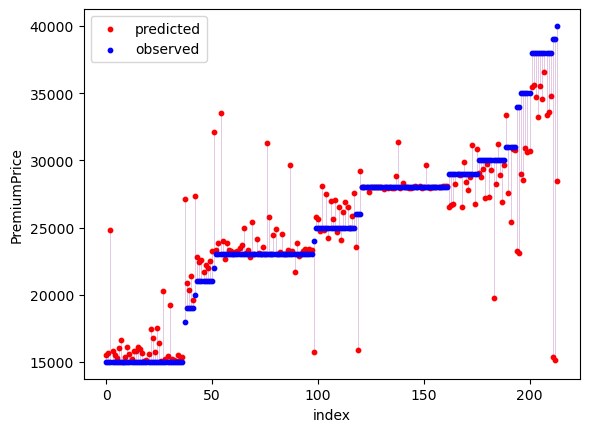

In [53]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [54]:
pred = best_forest_rgrid.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

1087.1798119841073

### GridSearch

In [35]:
from sklearn.model_selection import GridSearchCV

In [136]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [137]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 5, 6],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 300, 500]
}

In [138]:
forest_reg2 = RandomForestRegressor(random_state=42)

In [139]:
forest_grid = GridSearchCV(estimator = forest_reg2, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [140]:
score = forest_grid.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


#### saving

In [141]:
#joblib.dump(score, "forest2.pkl")
#score = joblib.load("forest2.pkl")

In [142]:
best_forest_grid = score.best_estimator_

In [143]:
score.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 3,
 'n_estimators': 300}

In [144]:
pred = best_forest_grid.predict(X_test)

In [145]:
np.sqrt(mean_squared_error(y_test, pred))

2483.17506651143

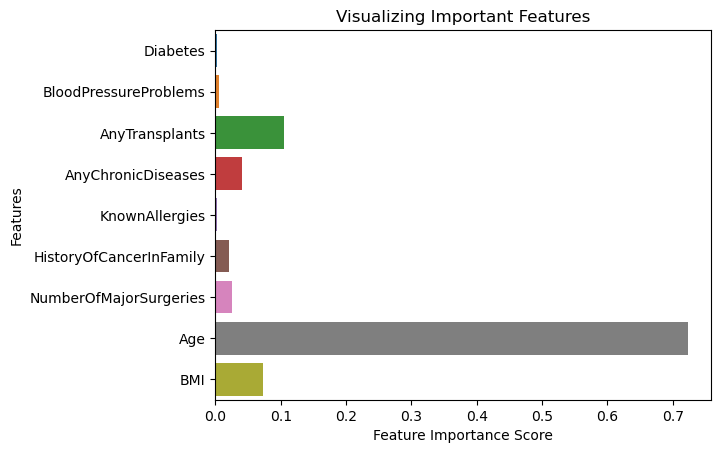

In [146]:
feature_imp1 = best_forest_grid.feature_importances_


sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

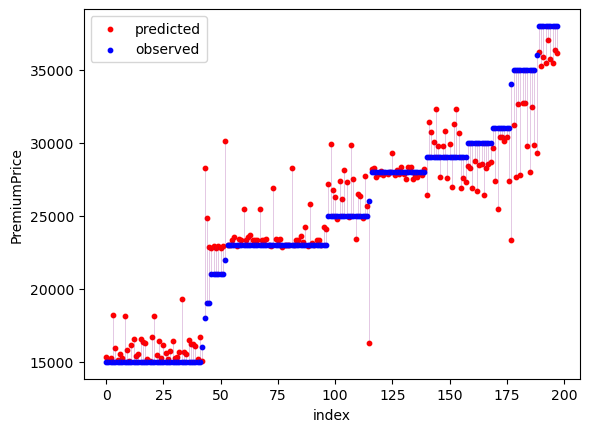

In [147]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [148]:
forest_cv = cross_val_score(score.best_estimator_, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [149]:
forest_rmse = np.sqrt(-forest_cv)
display_scores(forest_rmse)

Scores: [3589.57868875 2783.71864354 3898.98639365 3383.17498618 3664.01457677
 3877.17798536 3243.79613112 2135.72632769 2228.19940599 3399.64967845]
Mean: 3220.402281749883
Standard deviation: 602.9731947721225


# Deision tree

In [432]:
from sklearn.tree import DecisionTreeRegressor

In [433]:
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42, min_samples_leaf=2)

In [434]:
tree_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [435]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [436]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, random_state=42)

In [437]:
pred = tree_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

3663.19724099846

In [438]:
## train rmse
np.sqrt(mean_squared_error(y_train, tree_reg.predict(X_train)))

2498.9127020776523

### cv

In [439]:
cv = KFold(n_splits=10,shuffle=True,random_state=42)
scores = cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
display_scores(np.sqrt(-scores))

Scores: [3749.25397352 3801.07851905 4417.91642167 2275.54306928 3543.84412997
 4008.52255936 2777.52601341 2774.2959562  3434.23454581 3986.42893795]
Mean: 3476.8644126229765
Standard deviation: 635.5595428046367


In [440]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=42)
for depth in range (1,10):
     tree_regressor=DecisionTreeRegressor(max_depth=depth,random_state=42, min_samples_leaf=2)
     if tree_regressor.fit(X_train,y_train).tree_.max_depth<depth:
         break
     score=np.mean(cross_val_score(tree_regressor,X_train,y_train,scoring='neg_mean_squared_error', cv=crossvalidation,n_jobs=1))
     print(depth, np.sqrt(-score))

1 4335.112021947933
2 4107.961626941019
3 3683.6339078824853
4 3601.2710609094875
5 3674.3213931460223
6 3534.4762095979872
7 3659.532331437254
8 3779.71190876779
9 3835.717644801662


# AdaBoost

In [441]:
from sklearn.ensemble import AdaBoostRegressor

In [442]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [443]:
Dtree = DecisionTreeRegressor(max_depth=6, random_state=42)
model = AdaBoostRegressor(n_estimators=100, base_estimator=Dtree, learning_rate=0.0001, random_state=42)

In [444]:
model

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       random_state=42),
                  learning_rate=0.0001, n_estimators=100, random_state=42)

In [445]:
model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       random_state=42),
                  learning_rate=0.0001, n_estimators=100, random_state=42)

In [446]:
pred = model.predict(X_test)

In [447]:
np.sqrt(mean_squared_error(y_test, pred))

2854.61876333089

In [448]:
#train rmse
np.sqrt(mean_squared_error(y_train, model.predict(X_train)))

2163.2620339367113

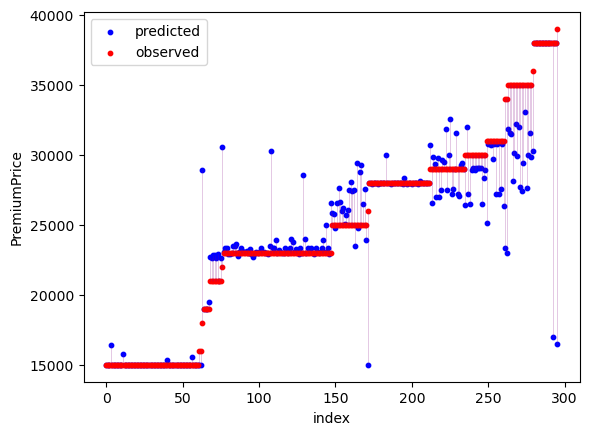

In [449]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [450]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
display_scores(np.sqrt(-scores))

Scores: [3592.16065306 3543.84695485 4099.6552954  2131.84860203 3304.76627416
 3484.00828493 3374.57624506 3201.80878288 3105.16632578 3714.13799221]
Mean: 3355.1975410354157
Standard deviation: 487.5380102310411


# XGBoost


In [451]:
import xgboost as xgb

In [452]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [453]:
model = xgb.XGBRegressor(max_depth=5, random_state=42, colsample_bytree=0.5, subsample=0.5, eta=0.1)

In [454]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [455]:
pred = model.predict(X_test)

In [456]:
np.sqrt(mean_squared_error(y_test, pred))

3122.06448666145

In [457]:
#train rmse
np.sqrt(mean_squared_error(y_train, model.predict(X_train)))

2166.5990225822766

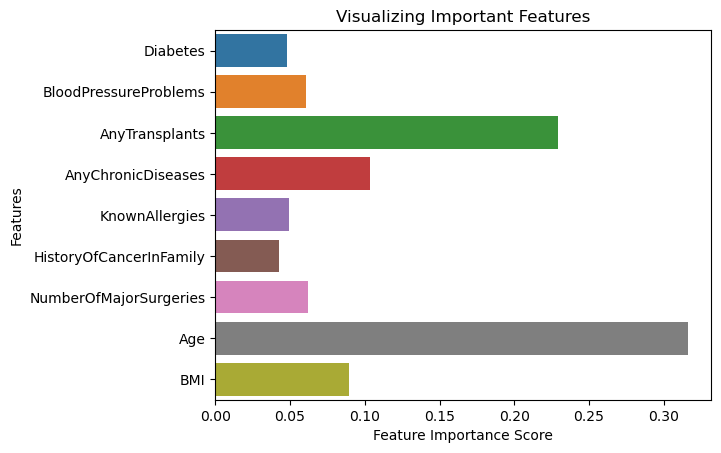

In [458]:
feature_imp1 = model.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [459]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, 
                             scoring='neg_mean_squared_error',
                             cv=cv, n_jobs=-1)

In [460]:
display_scores(np.sqrt(-scores))

Scores: [4229.48175153 2987.80682041 4062.20776127 2994.48908853 3575.05074649
 3978.54707135 2992.98062876 3242.7659052  3109.05891648 4176.05635709]
Mean: 3534.8445047107184
Standard deviation: 502.168099098015


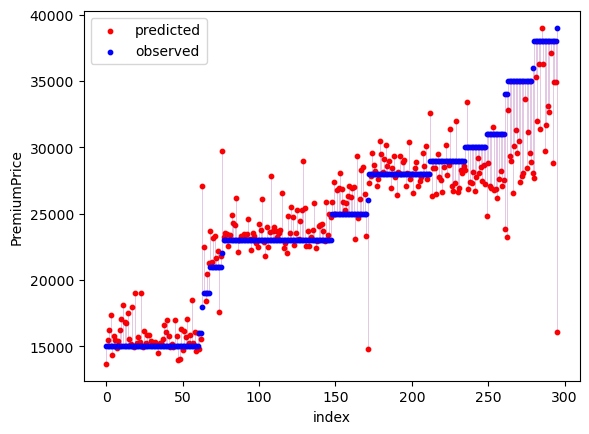

In [461]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# Stacking

## attempt1

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [41]:
from sklearn.model_selection import RepeatedKFold

In [42]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 return models

In [43]:
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
 return np.sqrt(-scores)

In [44]:
models = get_models()

>knn 4078.646 (530.102)
>cart 3621.613 (747.872)
>svm 6072.075 (303.383)


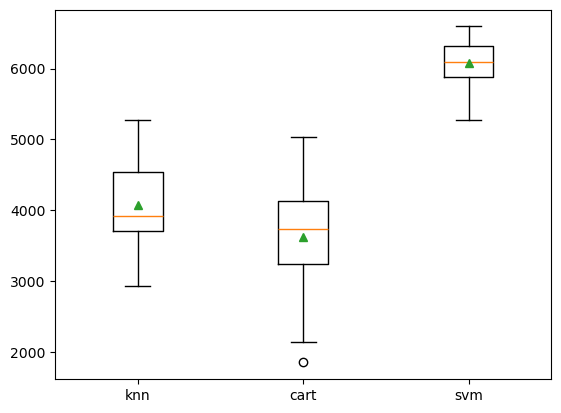

In [45]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [46]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 models['stacking'] = get_stacking()
 return models

In [47]:
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('svm', SVR()))
 # define meta learner model
 level1 = LinearRegression()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model

>knn 3598.646 (584.754)
>cart 3440.372 (868.422)
>svm 5988.586 (433.514)
>stacking 3146.628 (622.795)


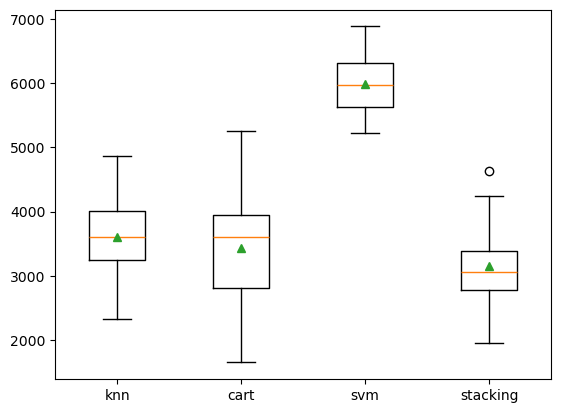

In [53]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## attempt2

In [54]:
level0 = list()
level0.append(('forest', RandomForestRegressor(random_state=42)))
level0.append(('xgboost', xgb.XGBRegressor()))

level1 = LinearRegression()

stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [50]:
models = dict()
models["forest"] = RandomForestRegressor(random_state=42)
models["xgboost"] = xgb.XGBRegressor()
models["stacking"] = stacked_model

In [51]:
models

{'forest': RandomForestRegressor(random_state=42),
 'xgboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'stacking': StackingRegressor(cv=5,
                   estimators=[('forest',
                                RandomForestRegressor(random_state=42)),
                               ('

>forest 2738.651 (720.777)
>xgboost 2945.616 (749.135)
>stacking 2735.382 (704.276)


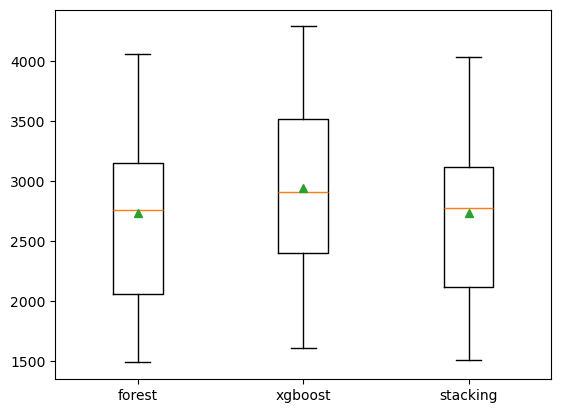

In [52]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# Cluster wise model fitting

In [26]:
dq = pd.read_csv("data.csv")

In [27]:
dq.drop(["BMI", "BMI_cat"], axis=1, inplace=True)

In [28]:
cluster1 = dq[dq.cluster == 1]
cluster2 = dq[dq.cluster == 2]
cluster3 = dq[dq.cluster == 3]

## cluster1

3528.449786341991
895.4240395065992


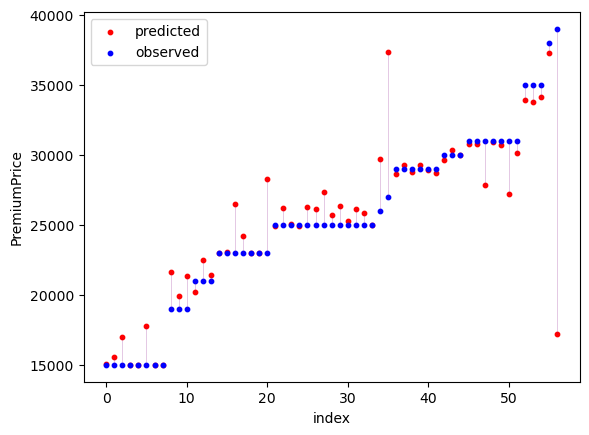

In [74]:
X_c1 = cluster1.drop("PremiumPrice", axis=1)
y_c1 = cluster1.PremiumPrice
X_c1_train, X_c1_test, y_c1_train, y_c1_test = train_test_split(X_c1, y_c1, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c1_train, y_c1_train)

pred_c1_test = forest_reg.predict(X_c1_test)

print(np.sqrt(mean_squared_error(y_c1_test, pred_c1_test)))

#train rmse
pred_c1_train = forest_reg.predict(X_c1_train)
print(np.sqrt(mean_squared_error(y_c1_train, pred_c1_train)))


temp = pd.DataFrame({'Observed':y_c1_test, 'predicted':pred_c1_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [75]:
scores = cross_val_score(forest_reg, X_c1_train, y_c1_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [3231.63035984 3022.75788269 2224.49505751 1340.55634136 3031.35139902
 3424.72340997 1308.46408467 1185.08117499 1931.15250563 2484.88979086]
Mean: 2318.5102006526
Standard deviation: 806.8096878414024


## cluster2

4989.134729242603
929.0640451551228


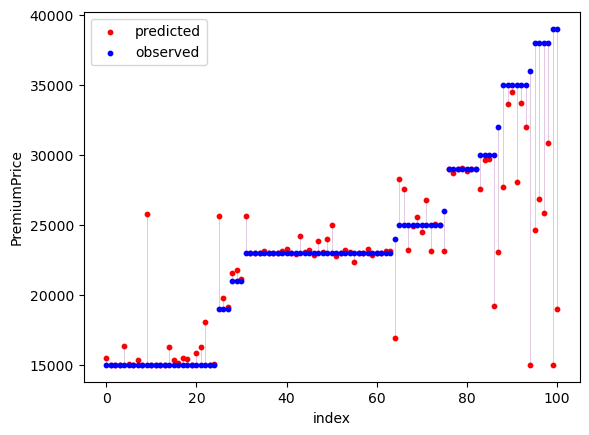

In [76]:
X_c2 = cluster2.drop("PremiumPrice", axis=1)
y_c2 = cluster2.PremiumPrice
X_c2_train, X_c2_test, y_c2_train, y_c2_test = train_test_split(X_c2, y_c2, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c2_train, y_c2_train)

pred_c2_test = forest_reg.predict(X_c2_test)

print(np.sqrt(mean_squared_error(y_c2_test, pred_c2_test)))

#train rmse
pred_c2_train = forest_reg.predict(X_c2_train)
print(np.sqrt(mean_squared_error(y_c2_train, pred_c2_train)))

temp = pd.DataFrame({'Observed':y_c2_test, 'predicted':pred_c2_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [77]:
scores = cross_val_score(forest_reg, X_c2_train, y_c2_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [2543.81603108 3987.41990515 1823.00164564 2171.16731276 3897.96357089
 1081.65729323 4017.35671804 3378.48264758 3458.47654322 2332.75748847]
Mean: 2869.2099156066834
Standard deviation: 969.762063696187


## cluster3

1610.9554618300283
766.6648550703234


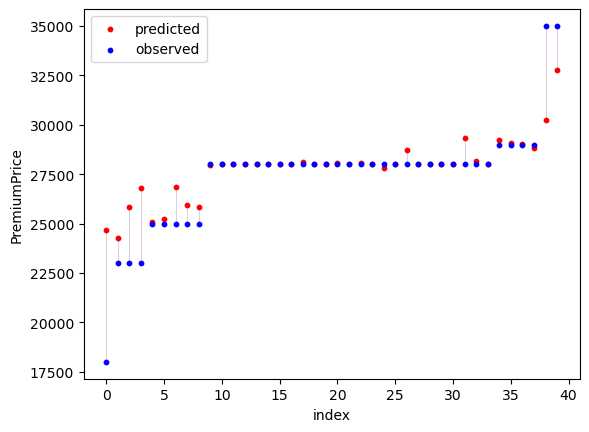

In [78]:
X_c3 = cluster3.drop("PremiumPrice", axis=1)
y_c3 = cluster3.PremiumPrice
X_c3_train, X_c3_test, y_c3_train, y_c3_test = train_test_split(X_c3, y_c3, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c3_train, y_c3_train)

pred_c3_test = forest_reg.predict(X_c3_test)

print(np.sqrt(mean_squared_error(y_c3_test, pred_c3_test)))

# train rmse
pred_c3_train = forest_reg.predict(X_c3_train)
print(np.sqrt(mean_squared_error(y_c3_train, pred_c3_train)))

temp = pd.DataFrame({'Observed':y_c3_test, 'predicted':pred_c3_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [79]:
scores = cross_val_score(forest_reg, X_c3_train, y_c3_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [ 260.43233286 2563.38033659 1562.74998    1402.98565566 2599.50956913
 1932.68272099 1953.8871513  1533.95730058 3211.49303284 1033.55273208]
Mean: 1805.4630812036557
Standard deviation: 806.0807573752162


In [80]:
y_c1_test.shape + y_c2_test.shape + y_c3_test.shape

(57, 101, 40)

In [81]:
dfc1 = pd.DataFrame({'test_observed':y_c1_test,
              'test_predicted':pred_c1_test})
dfc1.reset_index(drop=True, inplace=True)

dfc2 = pd.DataFrame({'test_observed':y_c2_test,
              'test_predicted':pred_c2_test})
dfc2.reset_index(drop=True, inplace=True)

dfc3 = pd.DataFrame({'test_observed':y_c3_test,
              'test_predicted':pred_c3_test})
dfc3.reset_index(drop=True, inplace=True)

dfc = pd.concat([dfc1, dfc2, dfc3])

In [82]:
np.sqrt(mean_squared_error(dfc.test_observed, dfc.test_predicted))

4099.453461971326

# Adding cluster label

In [83]:
dp = upsample().fit_transform(dq.copy())

In [84]:
X = dp.drop("PremiumPrice", axis=1)
y = dp.PremiumPrice.copy()

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
X_train = pipe.fit_transform(x_train.copy())
X_test = pipe.fit_transform(x_test.copy())

## Random Forest

In [87]:
forest_reg = RandomForestRegressor(random_state=42)

In [88]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [89]:
pred = forest_reg.predict(X_test)

In [90]:
np.sqrt(mean_squared_error(y_test, pred))

3761.327502284167

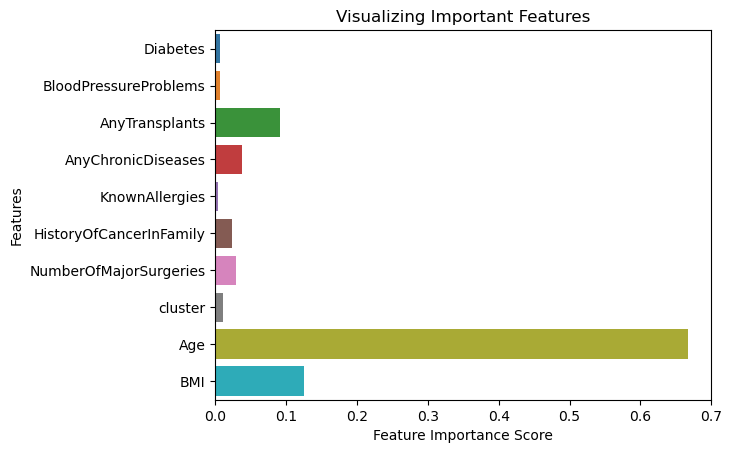

In [91]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

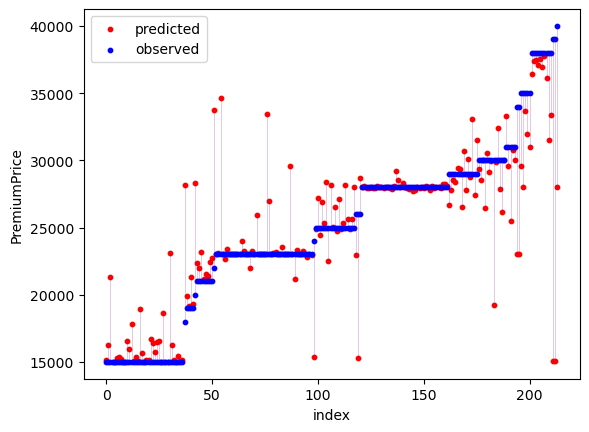

In [92]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cross validation

In [93]:
scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [3274.24250071 1849.36381267 1775.84012218 3059.57475385 2268.62267405
 3867.35276925 2859.97326191 2546.95527571 1961.94351421 3697.32876547]
Mean: 2716.1197450022637
Standard deviation: 719.1181025717005


## xgboost

In [108]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [109]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [110]:
pred = xgb_reg.predict(X_test)

In [111]:
np.sqrt(mean_squared_error(y_test, pred))

3711.374125298774

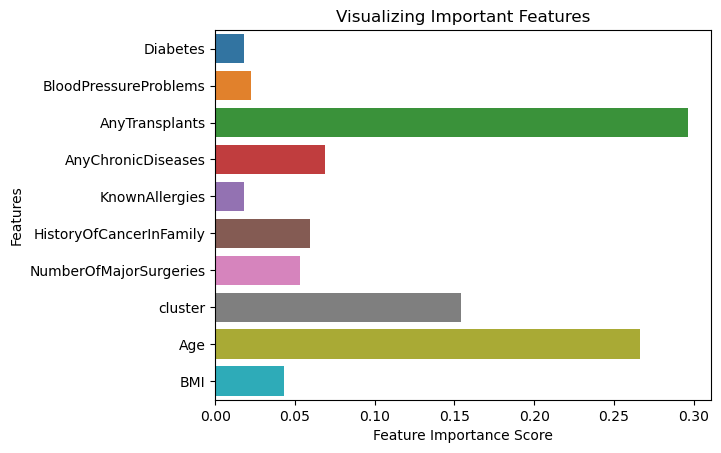

In [112]:
feature_imp1 = xgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### cross vaidation

In [113]:
scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

In [114]:
scores = np.sqrt(-scores)

In [115]:
display_scores(scores)

Scores: [3722.37943274 2340.43957688 1556.18977672 3403.55792529 2712.61894467
 3969.14128059 2537.18222602 2625.41695922 2120.0744036  3542.41159642]
Mean: 2852.9412122152635
Standard deviation: 737.0787556316893


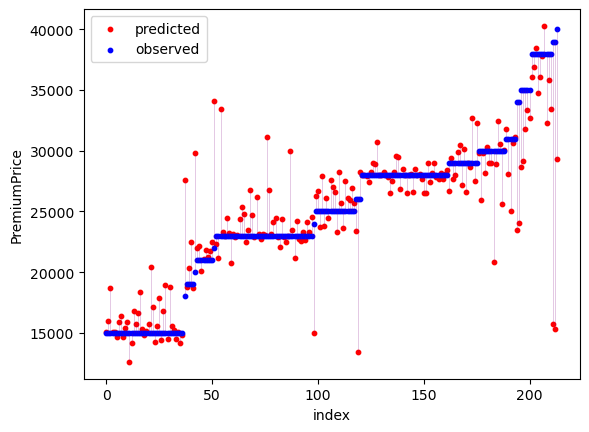

In [116]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# Factor Analysis Components Regression

In [101]:
fct = pd.read_csv("factor.csv")

In [102]:
X = fct.copy()

In [103]:
y = df.PremiumPrice.copy()

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Random forest

In [105]:
forest_reg = RandomForestRegressor()

In [106]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [107]:
pred = forest_reg.predict(X_test)

In [108]:
np.sqrt(mean_squared_error(y_test, pred))

3486.747203427008

In [109]:
scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [110]:
scores = np.sqrt(-scores)

In [111]:
display_scores(scores)

Scores: [4199.09061885 3812.35632641 3556.15921388 4153.50103961 3596.28394706
 4207.78106833 4154.22661084 3569.86862858 2805.78111981 3928.45405752]
Mean: 3798.3502630881585
Standard deviation: 416.5350279371173


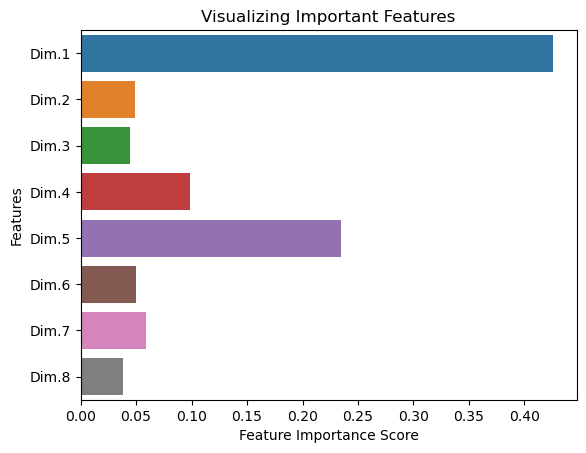

In [112]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

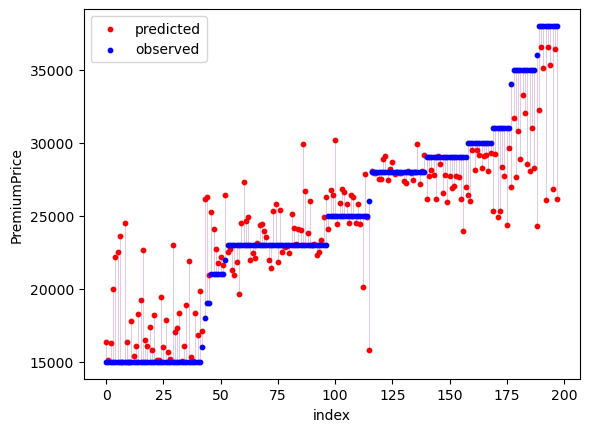

In [113]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## XGBoost

In [114]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [115]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [116]:
pred = xgb_reg.predict(X_test)

In [117]:
np.sqrt(mean_squared_error(y_test, pred))

3514.1452270275063

In [118]:
scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [119]:
scores = np.sqrt(-scores)

In [120]:
display_scores(scores)

Scores: [4662.22691682 3893.09128372 4118.28264508 4105.64214189 3601.5863421
 4378.97024244 4203.16461578 3637.87452119 3081.34424207 3960.65136234]
Mean: 3964.283431343744
Standard deviation: 422.2093798464794


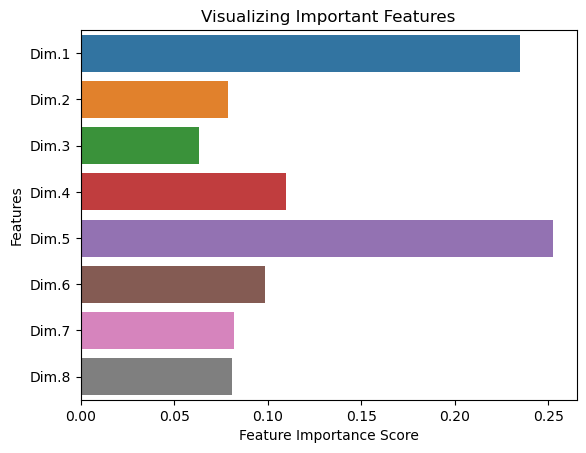

In [121]:
feature_imp1 = xgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

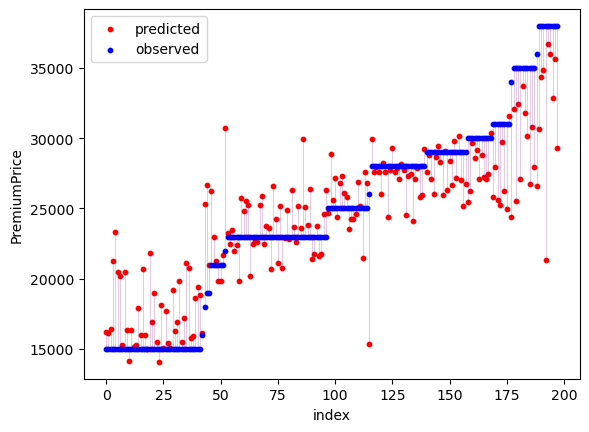

In [122]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# experiment

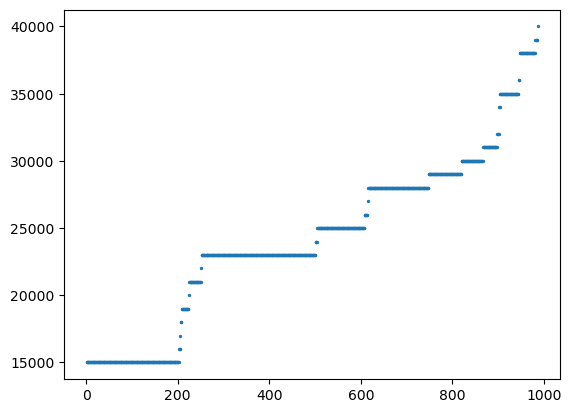

In [137]:
temp = dq.PremiumPrice.sort_values()
plt.scatter(np.arange(1, len(temp) + 1, 1), temp, s=2)

In [138]:
np.unique(df.PremiumPrice)

array([15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000,
       24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000,
       34000, 35000, 36000, 38000, 39000, 40000], dtype=int64)

In [139]:
len(np.unique(df.PremiumPrice))

24

In [152]:
def outlierDetection(column_name, tbl):
    Q1 = tbl[column_name].quantile(0.25)
    Q3 = tbl[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (tbl[column_name] < lower_bound) | (tbl[column_name] > upper_bound)
    outlier_indices = tbl.index[outliers]
    return outlier_indices

In [164]:
outlierDetection('PremiumPrice', dt)

Index([  7,  12,  14,  19,  21,  26,  30,  32,  33,  38,
       ...
       949, 953, 956, 958, 961, 964, 965, 966, 968, 969],
      dtype='int64', length=244)

In [156]:
outlierDetection('Age', df)

Index([], dtype='int64')

In [159]:
outlierDetection('BMI', X_train)

Index([756,  97, 155, 172,  24, 222, 180, 225,  26, 151, 183, 206, 779, 200,
       201, 189, 130],
      dtype='int64')

In [49]:
tf = ColumnTransformer([
    ('targetenc', TargetEncoder(categories='auto', smooth='auto', target_type="continuous"), ["NumberOfMajorSurgeries"])
])

In [52]:
temp = tf.fit_transform(X_train.copy(), y_train.copy())

In [53]:
np.unique(temp)

array([22581.4195302 , 22955.93872023, 23064.5372572 , 23081.6061072 ,
       23101.81934862, 24022.01373298, 24457.49172855, 24601.9060784 ,
       24822.10526771, 24927.06659167, 27972.62327636, 28000.        ,
       28100.1192746 , 28128.63204563, 28130.19383107, 28179.32947531])

In [42]:
temp_forest = RandomForestRegressor()

In [43]:
temp_forest.fit(temp, y_train)

RandomForestRegressor()